# Исследование рынка видеоигр

**Исходные данные:** \
Из открытых источников доступны исторические данные о продажах игр в различных регионах, их возрастной рейтинг, оценки пользователей и экспертов, жанры и платформы. \
**Задачи исследования:** \
Проанализировать продажи по годам на различных платформах \
Таким образом выявить актиуальные игровые консоли и перспективы на грядущий год \
Выяснить, влияют ли на продажи оценки пользователей и критиков \
Составить портрет пользователя каждого региона \
Проверить две гипотезы о влиянии возрастного рейтинга на продажи \
**Цель исследования:** \
Результат исследования поможет сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Знакомство с данными

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [52]:
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Предобработка данных

### Проверка данных на наличие явных дубликатов

In [54]:
data.duplicated().sum()

0

### Переименование столбцов

Приводим названия столбцов к единому нижнему регистру

In [55]:
data.columns = data.columns.str.lower()

### Работа с пропусками

Прежде чем приступать к изменению типов данных, необходимо обработать пропуски, поскольку значения NaN в некоторых столбцах мешают нам изменить тип данных на подходящий.

In [56]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

В столбцах name, year_of_release и genre нам придется пожертвовать строками с пропущенными значениями, так как корректно заменить их не получится. Благо, они составляют менее 2% всех данных, поэтому на качество данных это не повлияет.

In [57]:
data.dropna(subset = ['name', 'year_of_release', 'genre'], inplace = True)

Со столбцом rating разберемся поподробнее, для чего выведем все уникальные значения этого столбца и их количество:

In [58]:
data['rating'].value_counts()

rating
E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: count, dtype: int64

Согласно классификации ESRB рейтинги обозначаются следующим образом: \
«E» («Everyone») — «Для всех» \
«T» («Teen») — «Подросткам» \
«M» («Mature») — «Для взрослых» \
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше» \
«EC» («Early childhood») — «Для детей младшего возраста» \
«AO» («Adults Only 18+») — «Только для взрослых» \
«RP» («Rating Pending») — «Рейтинг ожидается» \
\
«K-A» («Kids to Adults») - первоначальный вариант, эквивалентный рейтингу «E10+» \
\
Для обработки этого столбца необходимо рейтинг «K-A» преобразовать в «E10+», а пропуски заполним значением unknown. Также рейтинг «RP» заменим на unknown, поскольку такая игра всего одна и «RP» означает, что рейтинг еще не определен.

In [59]:
data['rating'] = data['rating'].replace('K-A', 'E10+').fillna('unknown').replace('RP', 'unknown')

data['rating'].value_counts()

rating
unknown    6677
E          3921
T          2905
M          1536
E10+       1396
EC            8
AO            1
Name: count, dtype: int64

In [60]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating                0
dtype: int64

В столбцах critic_score и user_score мы не можем допустить пропусков, поскольку эти столбца понадобятся нам для дальнейшего анализа. Но и просто удалить их мы не можем, поскольку в таком случае потеряем половину данных. Оптимальным решением будет поставить "заглушку" на такие пропуски, а в дальнейшем при обращении с этими данными ставить фильтрацию \
Для начала нам нужно избавиться от значения "tbd", которое встречается в столбце user_score. \
TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков, которые надо заполнить. \
В нашем случае это эквивалентно пропуску, а поскольку для анализа нам необходимо заполнить пропуски в этих столбцах, правильным будет преобразовать tbd в Nan

In [61]:
data['user_score'] = data['user_score'].replace('tbd', np.NaN).astype(float)

In [62]:
data = data.fillna(-1000)

In [63]:
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

#### Промежуточный вывод

Пропуски в столбцах с названием игры, датой выхода и жанром могли появиться, скорее всего, в результате ошибки в данных, в то время как пропуски в столбцах с оценками могли, помимо этого, появиться из-за того, что игра очень старая или малоизвестная, поэтому не сохранилось или даже не было данных о ее оценках по мнению критиков и/или игроков. \
В столбце с рейтингом пропуски также могли появиться из-за другой системы оценивания рейтинга (например, в Японии, о чем будет подробнее сказано ниже)

### Изменение типов данных

Столбец year_of_release необходимо привести к типу int, поскольку все значения целочисленные \
Столбец user_score мы уже привели к типу float на предыдущем шаге

In [64]:
data['year_of_release'] = data['year_of_release'].astype(int)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


In [66]:
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1000.0,-1000.0,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1000.0,-1000.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1000.0,-1000.0,unknown
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1000.0,-1000.0,unknown
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1000.0,-1000.0,unknown
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,-1000.0,-1000.0,unknown


### Добавляем столбец с общими продажами по всем регионам

In [67]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

### Промежуточный вывод

В этой части работы мы провели предобработку данных, избавились от пропусков, где это возможно, изменили неверный тип данных в некоторых столбцах. В ходе обработки мы пожертвовали 273 строки из-за невозможности восполнить пропуски, что составляет менее 2% данных

## Исследовательский анализ данных

### Выпуск игр по годам

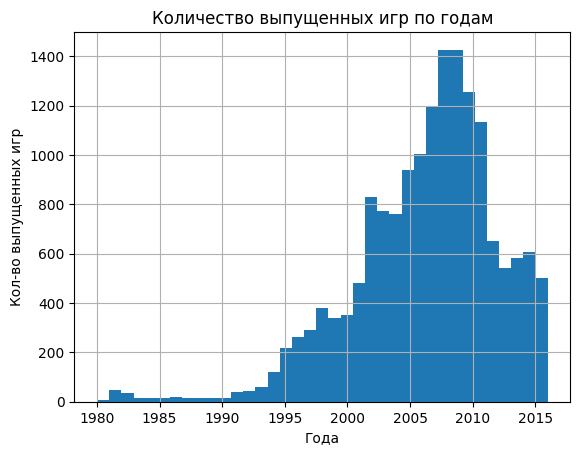

In [68]:
data['year_of_release'].hist(bins=37).set_title('Количество выпущенных игр по годам');
plt.xlabel('Года');
plt.ylabel('Кол-во выпущенных игр');

Как мы видим, подавляющее большинство игр было выпущено после 2000 года (88%), при этом самый пик приходится на 2008-2009 год.

### Продажи по годам на платформах

Определим Топ5 платформ по общим продажам во всех регионах.

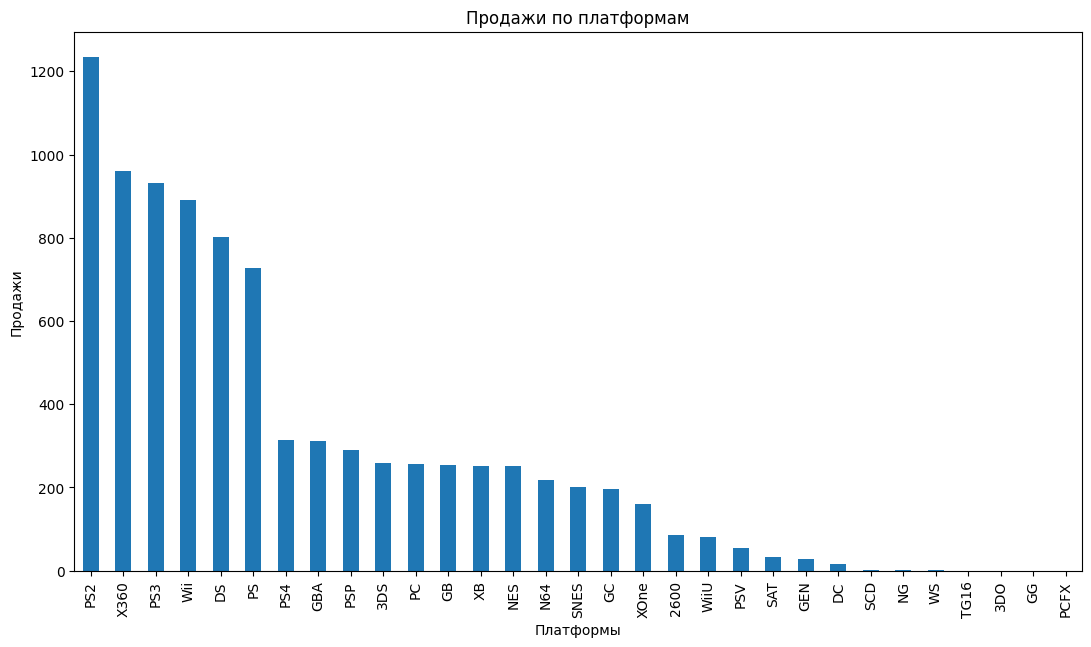

In [69]:
platforms_sales = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
platforms_sales.plot(kind='bar', figsize=(13,7)).set_title('Продажи по платформам');
plt.xlabel('Платформы');
plt.ylabel('Продажи');

In [70]:
platforms_sales.head(5)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
Name: total_sales, dtype: float64

Для каждой из них составим график по годам:

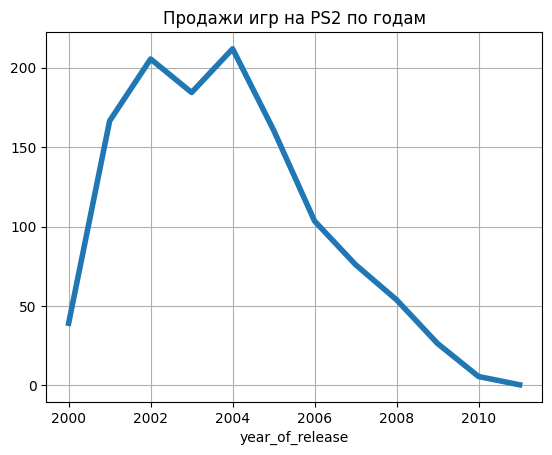

In [71]:
data.query('platform == "PS2"').groupby('year_of_release')['total_sales'].sum().plot(linewidth=4, grid=True).set_title('Продажи игр на PS2 по годам');

Основная масса продаж пришлась на период с 2001 по 2005 год

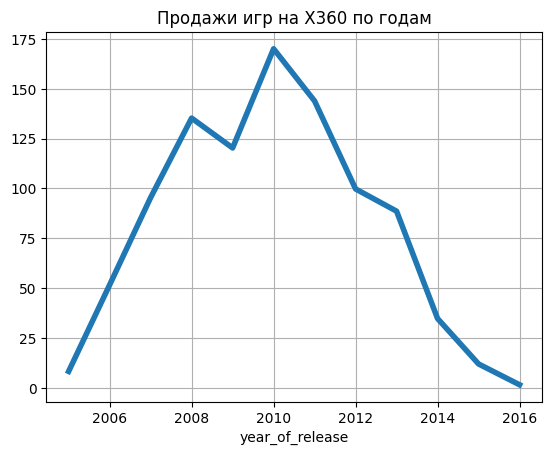

In [72]:
data.query('platform == "X360"').groupby('year_of_release')['total_sales'].sum().plot(linewidth=4, grid=True).set_title('Продажи игр на X360 по годам');

Основная масса продаж пришлась на период с 2008 по 2012 год

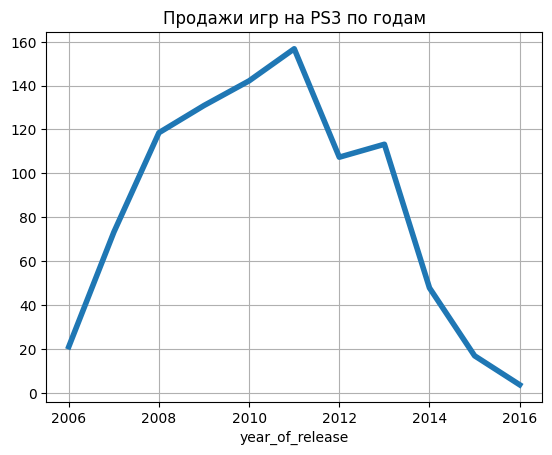

In [73]:
data.query('platform == "PS3"').groupby('year_of_release')['total_sales'].sum().plot(linewidth=4, grid=True).set_title('Продажи игр на PS3 по годам');

Основная масса продаж пришлась на период с 2008 по 2013 год

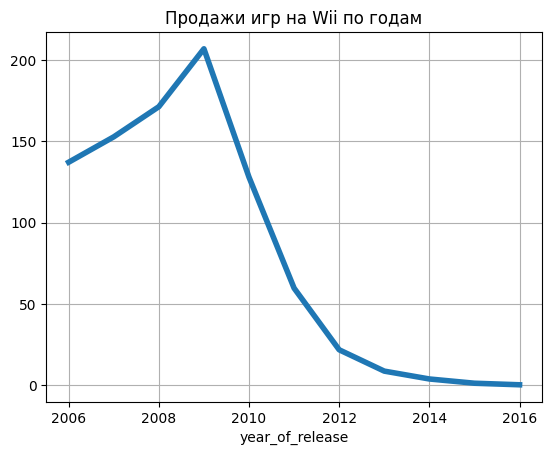

In [74]:
data.query('platform == "Wii"').groupby('year_of_release')['total_sales'].sum().plot(linewidth=4, grid=True).set_title('Продажи игр на Wii по годам');

Основная масса продаж пришлась на период с 2006 по 2010 год

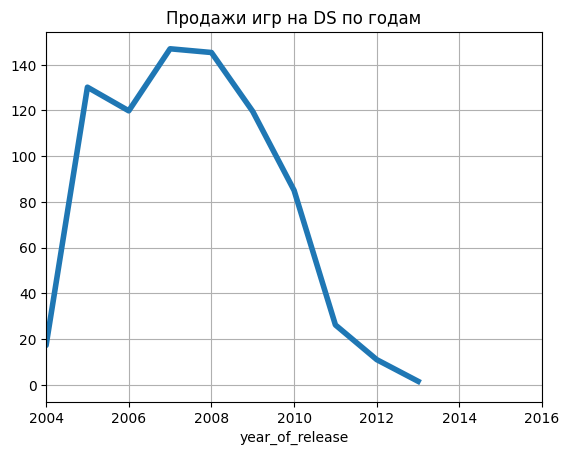

In [75]:
data.query('platform == "DS"').groupby('year_of_release')['total_sales'].sum().plot(linewidth=4, xlim=(2004, 2016), grid=True).set_title('Продажи игр на DS по годам');

Практически вся масса продаж пришлась на период с 2005 по 2010 год

**Вывод:** \
Консоли в среднем "живут" и активно продаются 4-5 лет. Таким образом, актуальной игровой консолью будет та, высокие продажи игр на которой начались не ранее, чем в 2014-2016 годах, что мы и выделим как актуальный период для дальнейшего анализа.

In [76]:
old_data = data
data = old_data.query('year_of_release >= 2014')

### Актуальные игровые консоли

In [77]:
data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head()

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
Name: total_sales, dtype: float64

Вот Топ5 игровых платформ по продажам за последние 3 года. Составим график, чтобы отследить их перспективы в динамике.

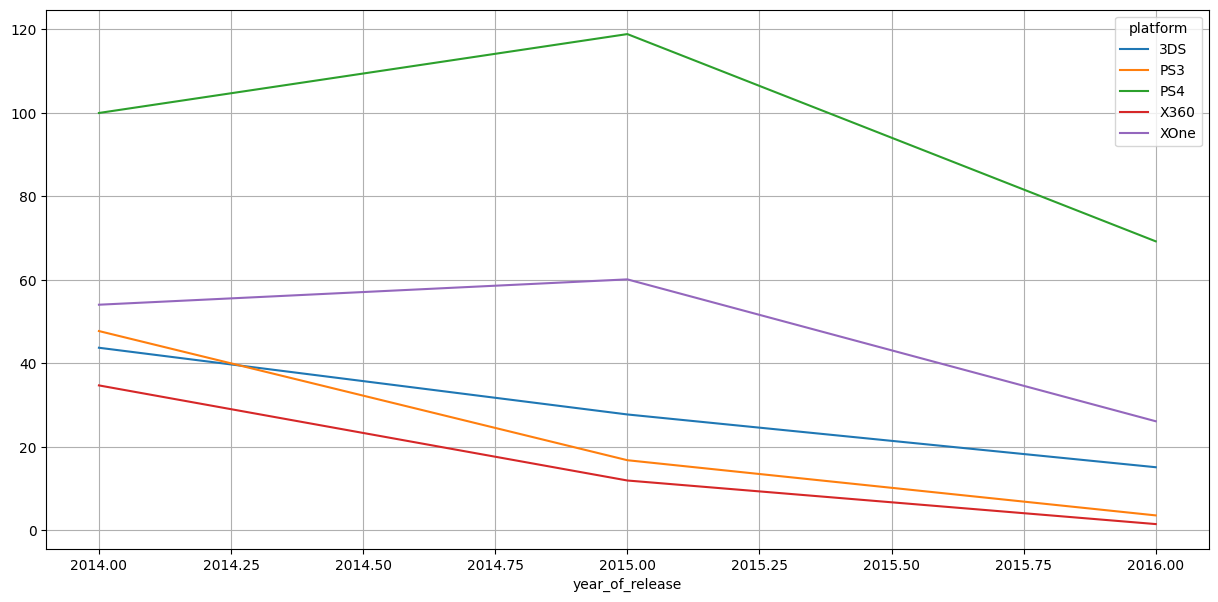

In [78]:
data.query('platform in ["PS4", "PS3", "XOne", "3DS", "X360"]').pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum').plot(grid=True, figsize=(15, 7));

Хоть и у всех платформ наблюдается отрицательная динамика за последний год, однако лидирующими по общему объему продаж остаются консоли PS4 и XOne. Их мы и определим в качестве наиболее перспективных игровых платформ

### «Ящик с усами» по глобальным продажам игр в разбивке по платформам

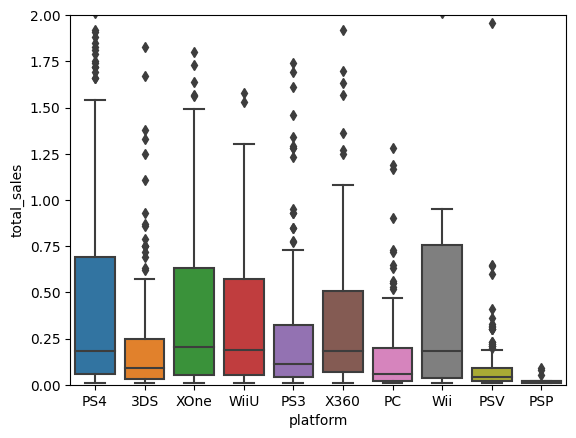

In [79]:
sns.boxplot(x=data['platform'], y=data['total_sales']).set_ylim([0,2]);

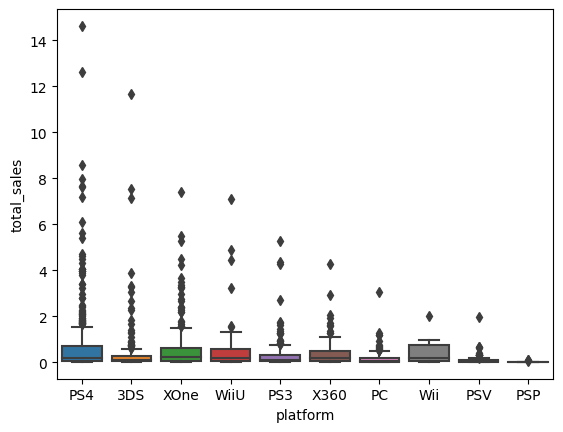

In [80]:
sns.boxplot(x=data['platform'], y=data['total_sales']);

На графике видно, что высокое медианное значение у PS4, XOne, WiiU, X360 и Wii, однако верхняя граница нормального распределения у PS4 и XOne выше, чем у остальных, что означает, что значения, превышающие ожидаемые, встречаются чаще, что делает эти две игровые платформы потенциально более прибыльными. Это вполне соотносится с ранее сделанными выводами, а в сравнении PS4 и XOne между собой по прежнему выигрывает PS4.

### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

Для рассмотрения возьмем самую перспективную по промежуточным итогам нашего исследования платформу - PS4

In [81]:
PS4_data_critic = data.query('platform == "PS4" and critic_score != -1000')
PS4_data_user = data.query('platform == "PS4" and user_score != -1000')

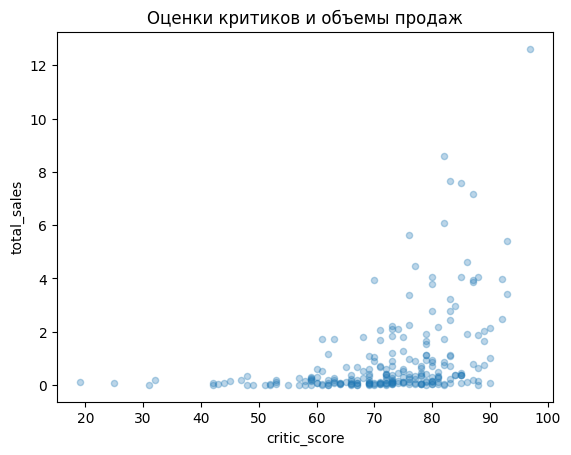

In [82]:
PS4_data_critic.plot.scatter('critic_score', 'total_sales', alpha=0.3).set_title('Оценки критиков и объемы продаж');
PS4_data_critic['critic_score'].corr(PS4_data_critic['total_sales']);

Небольшая положительная корреляция между оценками критиков и объемами продаж наблюдается: действительно ни одна игра, оцененная меньше чем на 70 баллов, не продавалась более чем на 2 млн. Тем не менее, несмотря на некоторые наблюдаемые закономерности, корреляция нелинейна.

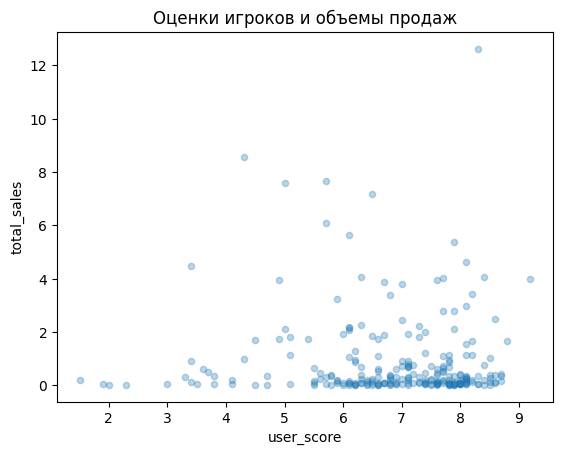

In [83]:
PS4_data_user.plot.scatter('user_score', 'total_sales', alpha=0.3).set_title('Оценки игроков и объемы продаж');
PS4_data_user['user_score'].corr(PS4_data_user['total_sales']);

Корреляция между оценками игроков и объемами продаж отсутствует, хотя и видны более частые и более сильные (но тем не менее единичные) всплески продаж при высоких оценках.

Проделаем то же самое для четырех других ТОП-платформ

XOne
Корреляция:
0.42867694370333187


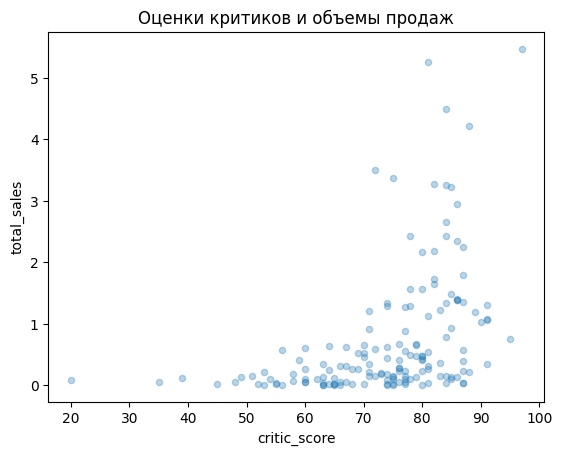

3DS
Корреляция:
0.314117492869051


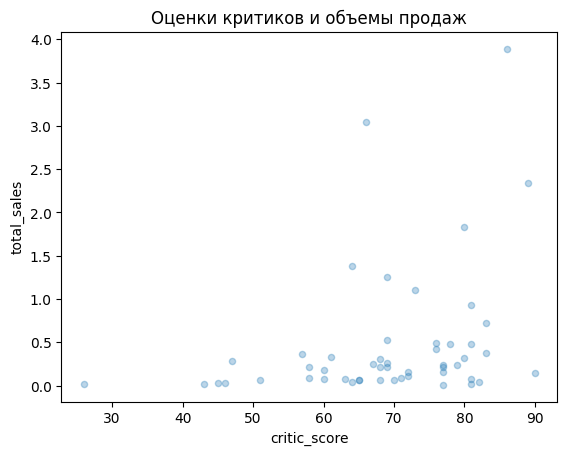

PS3
Корреляция:
0.44657460493190704


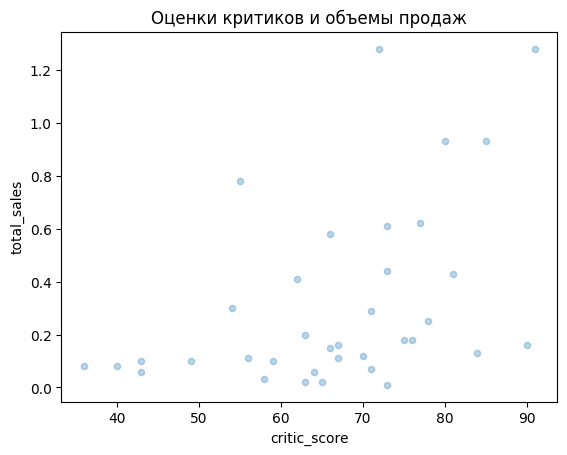

X360
Корреляция:
0.5257228356581523


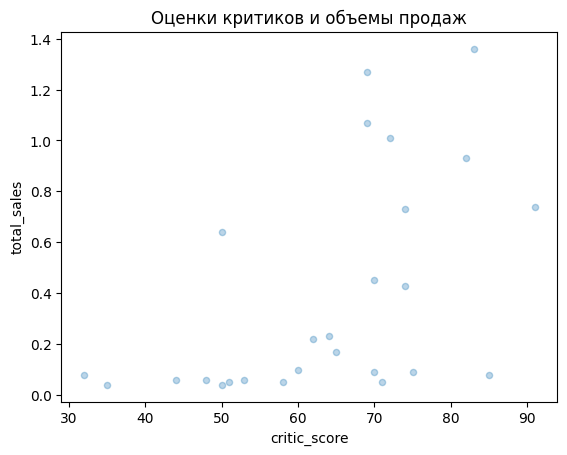

In [84]:
other_top_platforms = ['XOne', '3DS', 'PS3', 'X360']
for console in other_top_platforms:
    platform_data = data.loc[data['platform'] == console].loc[data['critic_score'] != -1000]
    print(console)
    print('Корреляция:')
    platform_data.plot.scatter('critic_score', 'total_sales', alpha=0.3).set_title('Оценки критиков и объемы продаж');
    print(platform_data['critic_score'].corr(platform_data['total_sales']))
    plt.show()

XOne
Корреляция:
-0.07038392806475809


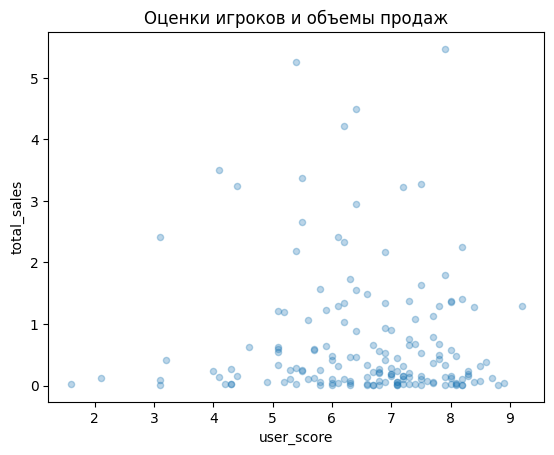

3DS
Корреляция:
0.2151932718527028


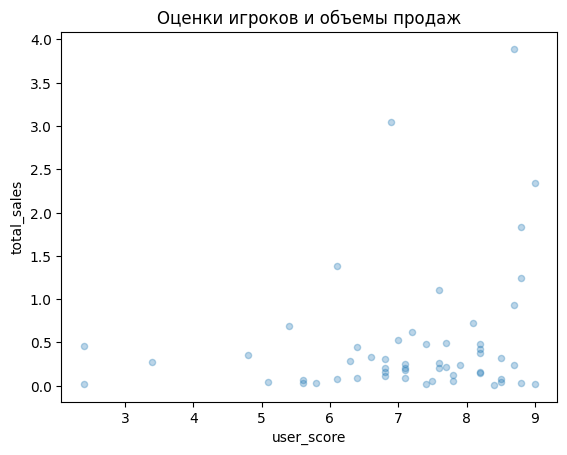

PS3
Корреляция:
-0.16676141347662118


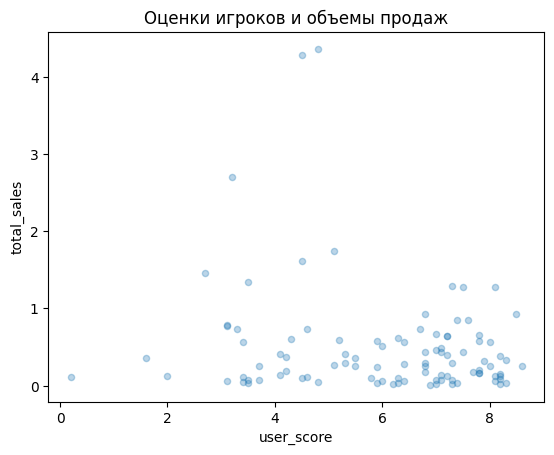

X360
Корреляция:
-0.138444570945665


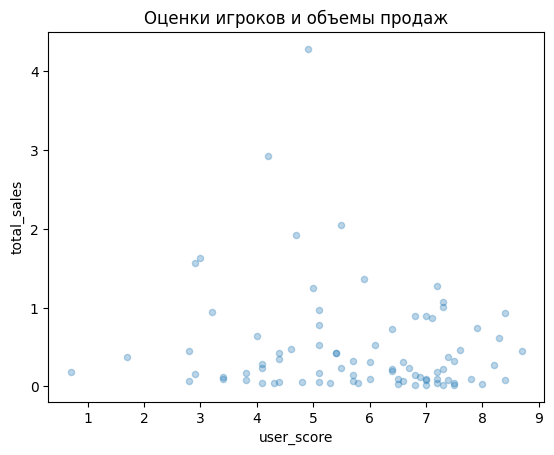

In [85]:
other_top_platforms = ['XOne', '3DS', 'PS3', 'X360']
for console in other_top_platforms:
    platform_data = data.loc[data['platform'] == console].loc[data['user_score'] != -1000]
    print(console)
    print('Корреляция:')
    platform_data.plot.scatter('user_score', 'total_sales', alpha=0.3).set_title('Оценки игроков и объемы продаж');
    print(platform_data['user_score'].corr(platform_data['total_sales']))
    plt.show() 

Как видно из представленных графиков, картина по разным платформам различается не сильно, а из того, что мы видим, можно сделать вывод, что оценки игроков не влияют на продажи, поскольку для 4 из 5 проанализированных платформ корреляция, хоть и незначительна, но даже отрицательная.

### Общее распределение игр по жанрам

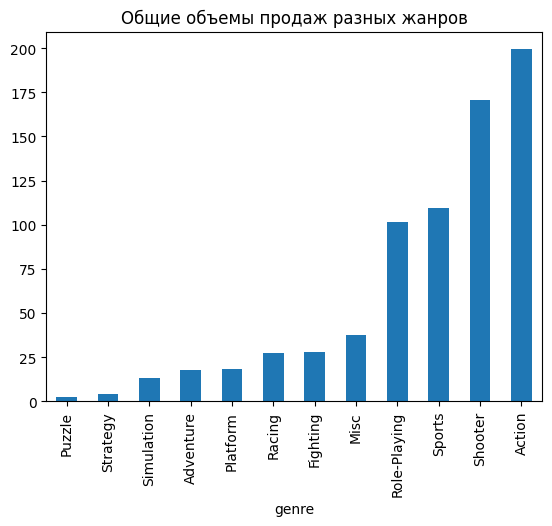

In [86]:
data.groupby('genre')['total_sales'].sum().sort_values().plot(kind='bar').set_title('Общие объемы продаж разных жанров');

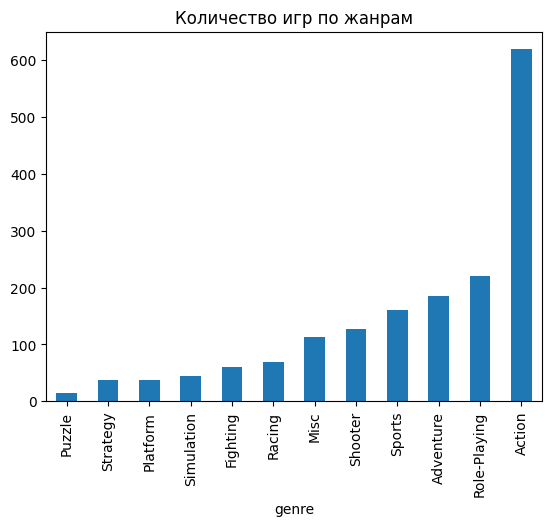

In [87]:
data.groupby('genre')['total_sales'].count().sort_values().plot(kind='bar').set_title('Количество игр по жанрам');

In [88]:
genre_sales = data.pivot_table(index='genre', values='total_sales', aggfunc=['count', 'sum', 'median'])
genre_sales.columns = ['count', 'sales', 'median']
genre_sales['ratio'] = (genre_sales['sales'] / genre_sales['count']).round(2)
genre_sales.sort_values('ratio')

,count,sales,median,ratio
genre,,,,
Adventure,185,17.55,0.030,0.09
Strategy,37,3.96,0.060,0.11
Puzzle,14,2.21,0.045,0.16
Simulation,44,13.13,0.100,0.30
Action,619,199.36,0.090,0.32
Misc,113,37.55,0.090,0.33
Racing,69,27.52,0.090,0.40
Role-Playing,221,101.44,0.110,0.46
Fighting,60,28.22,0.125,0.47


Наглядно мы видим, что большая часть выпускаемых игр создаются в жанре Action, они же имеют и самые большие объемы продаж. Интереснее дело обстоит с жанром Shooter, поскольку они занимают пятое место по количеству игр, но второе место по продажам.
Наиболее прибыльными с точки зрени соотношения продаж к количеству игр, являются Шутеры и Спорт, причем Шутеры лидируют с двукратным отрывом. \
Самыми непопулярными и низкоприбыльными жанрами являются Адвенчуры, Стратегии и Паззлы

## Портрет пользователя каждого региона

Сейчас мы составим портрет пользователя для каждого региона и определим Топ5 самых популярных платформ, жанров и рейтингов.

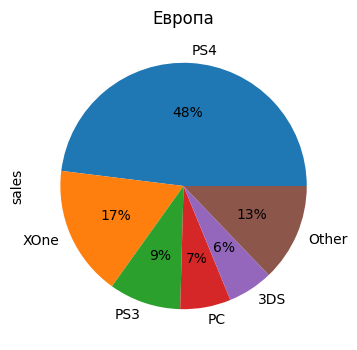

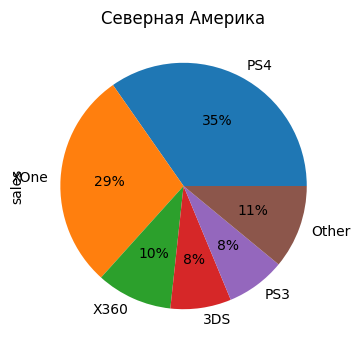

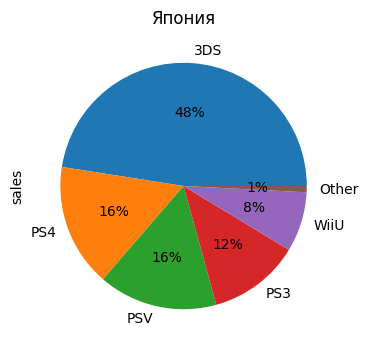

In [89]:
eu_platform = data.pivot_table(index='platform', values='eu_sales', aggfunc=['sum'])
eu_platform.columns = ['sales']
eu_platform = eu_platform.sort_values('sales', ascending=False)
eu_platform_other = eu_platform['sales'].iloc[5:].sum()
eu_platform = eu_platform.head(5)
eu_platform.loc['Other', 'sales'] = eu_platform_other

na_platform = data.pivot_table(index='platform', values='na_sales', aggfunc=['sum'])
na_platform.columns = ['sales']
na_platform = na_platform.sort_values('sales', ascending=False)
na_platform_other = na_platform['sales'].iloc[5:].sum()
na_platform = na_platform.head(5)
na_platform.loc['Other', 'sales'] = na_platform_other

jp_platform = data.pivot_table(index='platform', values='jp_sales', aggfunc=['sum'])
jp_platform.columns = ['sales']
jp_platform = jp_platform.sort_values('sales', ascending=False)
jp_platform_other = jp_platform['sales'].iloc[5:].sum()
jp_platform = jp_platform.head(5)
jp_platform.loc['Other', 'sales'] = jp_platform_other


eu_platform.plot(kind='pie', y='sales', legend=False, autopct='%1.00F%%', figsize=(4,4)).set_title('Европа');
na_platform.plot(kind='pie', y='sales', legend=False, autopct='%1.0f%%', figsize=(4,4)).set_title('Северная Америка');
jp_platform.plot(kind='pie', y='sales', legend=False, autopct='%1.0f%%', figsize=(4,4)).set_title('Япония');

Половину всего рынка в Европе занимают игры на PS4, второе по значимости место занимает XOne. В совокупности они покрывают 65% всего рынка видоигр в Европе.

По сравнению с Европейским рынком, доля продаж на XOne выросла почти в два раза, в то время как на PS4 существенно сократилась. Вероятно, это связано с тем, что компания Microsoft более ориентирована на американский рынок, в то время как Sony ориентируется на оба рынка в равной степени. \
Интересным наблюдением является то, что ПК вообще не вошли в Топ5 платформ, хотя их доля на европейском рынке составляла 7%. Скорее всего, их доля оказалась меньше из-за возросшей доли X360, что объясняется вышеизложенной ориентацией компании Microsoft.

Половина рынка видоигр в Японии приходится на игровую консоль Nintendo 3DS, еще 44% осталются за различными консолями от Sony. При этом стоит отметить, что Microsoft вообще не имеет сколь-нибудь значимой доли продаж на территории Японии. Конкуренция между PS и Xbox на японском рынке продолжалась на протяжении десятилетия и закончилась капитальным провалом для Microsoft. Это ситуация изменится в 2022 году с появлением Xbox Series S, которая побъет рекорды продаж за последние 20 лет, однако по условию нашего исследования сейчас 2016 год, и позиции Microsoft на территории Японии ничтожно малы. \
В свою очередь Nintendo - родная японская консоль, ориентированная в первую очередь на собственно японский рынок, поэтому и удерживает лидирующее положение на рынке видеоигр.

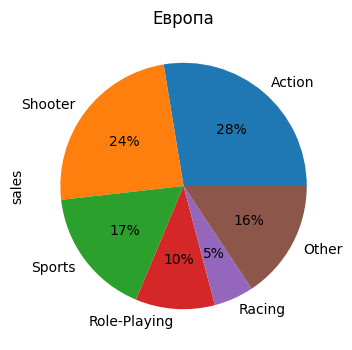

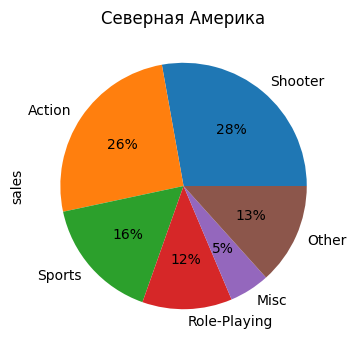

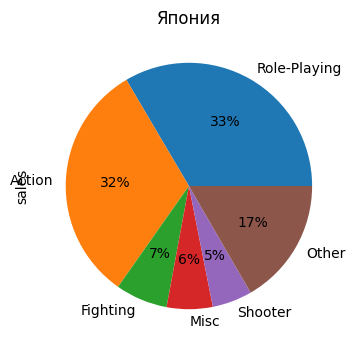

In [90]:
eu_genres = data.pivot_table(index='genre', values='eu_sales', aggfunc=['sum'])
eu_genres.columns = ['sales']
eu_genres = eu_genres.sort_values('sales', ascending=False)
eu_genres_other = eu_genres['sales'].iloc[5:].sum()
eu_genres = eu_genres.head(5)
eu_genres.loc['Other', 'sales'] = eu_genres_other

na_genre = data.pivot_table(index='genre', values='na_sales', aggfunc=['sum'])
na_genre.columns = ['sales']
na_genre = na_genre.sort_values('sales', ascending=False)
na_genre_other = na_genre['sales'].iloc[5:].sum()
na_genre = na_genre.head(5)
na_genre.loc['Other', 'sales'] = na_genre_other

jp_genre = data.pivot_table(index='genre', values='jp_sales', aggfunc=['sum'])
jp_genre.columns = ['sales']
jp_genre = jp_genre.sort_values('sales', ascending=False)
jp_genre_other = jp_genre['sales'].iloc[5:].sum()
jp_genre = jp_genre.head(5)
jp_genre.loc['Other', 'sales'] = jp_genre_other


eu_genres.plot(kind='pie', y='sales', legend=False, autopct='%1.00F%%', figsize=(4,4)).set_title('Европа');
na_genre.plot(kind='pie', y='sales', legend=False, autopct='%1.0f%%', figsize=(4,4)).set_title('Северная Америка');
jp_genre.plot(kind='pie', y='sales', legend=False, autopct='%1.0f%%', figsize=(4,4)).set_title('Япония');

В Европе Экшены и Шутеры имеют почти равные доли на рынке видоигр и в совокупности занимают 50% от всех продаж в регионе.

На американском рынке не наблюдается практически никаких отличий от европейского рынка. Это связано со схожим менталитетом и интересами европейцев и американцев, а так же с тем, что разнообразие видеоигр для них практически ничем не отличается, вне зависимости от игровой платформы

В Японии лидирующие позиции по жанрам удерживают Ролевые игры и Экшн, что в первую очередь связано с любовью японских геймеров к жанру JRPG (англ. Japanese Role-Playing Game), отдельному поджанру ролевых игр, который даже в названии указывает национальную специфику. \
Также в Топ попал жанр Файтингов, тоже крайне популярный в Японии еще со времен игровых автоматов. \
А вот Шутеры занимают лишь 5% рынка, что в 5-6 раз меньше, чем на американском и европейском рынках.

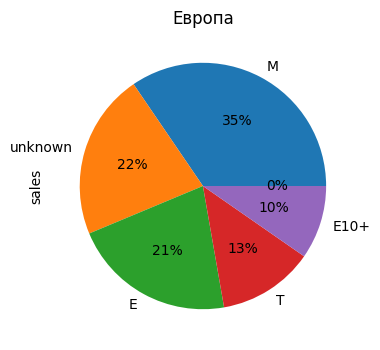

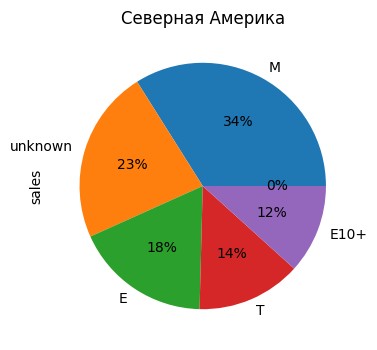

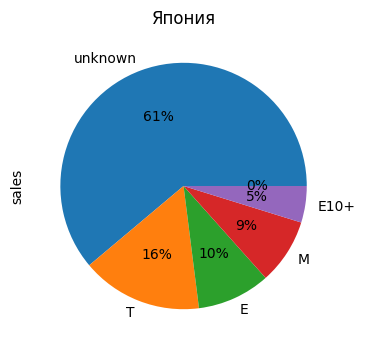

In [91]:
eu_rating = data.pivot_table(index='rating', values='eu_sales', aggfunc=['sum'])
eu_rating.columns = ['sales']
eu_rating = eu_rating.sort_values('sales', ascending=False)
eu_rating_other = eu_rating['sales'].iloc[5:].sum()
eu_rating = eu_rating.head(5)
eu_rating.loc['Other', 'sales'] = eu_rating_other

na_rating = data.pivot_table(index='rating', values='na_sales', aggfunc=['sum'])
na_rating.columns = ['sales']
na_rating = na_rating.sort_values('sales', ascending=False)
na_rating_other = na_rating['sales'].iloc[5:].sum()
na_rating = na_rating.head(5)
na_rating.loc['Other', 'sales'] = na_rating_other

jp_rating = data.pivot_table(index='rating', values='jp_sales', aggfunc=['sum'])
jp_rating.columns = ['sales']
jp_rating = jp_rating.sort_values('sales', ascending=False)
jp_rating_other = jp_rating['sales'].iloc[5:].sum()
jp_rating = jp_rating.head(5)
jp_rating.loc['Other', 'sales'] = jp_rating_other


eu_rating.plot(kind='pie', y='sales', legend=False, autopct='%1.00F%%', figsize=(4,4)).set_title('Европа');
na_rating.plot(kind='pie', y='sales', legend=False, autopct='%1.0f%%', figsize=(4,4)).set_title('Северная Америка');
jp_rating.plot(kind='pie', y='sales', legend=False, autopct='%1.0f%%', figsize=(4,4)).set_title('Япония');

Самую высокую долю (35%) всех продаж составляют игры рейтинга «M» («Mature») — «Для взрослых». В первую очередь это связно с большими объемами продаж Шутеров, что было показано ранее, которые в большинстве своем имеют рейтинг для взрослых из-за сцен насилия и жестокости.

Существенных отличий в распределении по рейтингам так же не наблюдается, что является следствием одинаковости жанровых предпочтений

Очень большой процент игр без рейтинга не позволяет корректно оценить их распределение. Связано это, скорее всего, с собственной системой рейтингов в Японии, которая существует отдельно от американского ESRB и европейского PEGI, и имеет другую систему оценивания. Вероятно, к рейтингу игр в Японии сложно корректно подобрать соответсвующий рейтинг ESRB, поэтому в данных так много пропусков.

**Влияет ли рейтинг ESRB на продажи в отдельном регионе?**

Рейтинг необходимо рассматривать в совокупности с жанром и целевой аудиторией игры. Рейтинг выступает скорее в зависимости от жанра, поэтому о прямом влиянии рейтинга на продажи мы не можем. На примере североамериканского рынка: если у Шутера будет рейтинг "M", это не окажет влияние на продажи, поскольку жанр подразумевает насилие и жестокость, и попытка понизить рейтинг для охвата большей аудитории (а это требует серьезной цензуры в отношении игрового контента), может вызвать недовольство основной целевой аудитории, что наоборот повредит продажам игры. И наоборот, если "семейная" игры (Симулятор или Спорт) получит несоответствующий высокий рейтинг, это так же повредит ее продажам. \
Поэтому продажи игры не находятся в прямой зависимости от рейтинга. Их следует рассматривать в совокупности с жанром, который выступает скорее определяющим фактором.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые \
Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC разные

In [92]:
xone_score = data.query('platform == "XOne" and user_score != -1000')['user_score']
pc_score = data.query('platform == "PC" and user_score != -1000')['user_score']

results = st.ttest_ind(pc_score, xone_score, equal_var=False)


alpha = 0.05

print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print()
print('Средние пользовательские оценки XOne:', xone_score.mean().round(2))
print('Средние пользовательские оценки PC:', pc_score.mean().round(2))

0.11601398086668835
Не получилось отвергнуть нулевую гипотезу

Средние пользовательские оценки XOne: 6.59
Средние пользовательские оценки PC: 6.3


Вероятность того, что Средние пользовательские рейтинги платформ Xbox One и PC одинаковые, оказалась довольно высока, что не позволяет нам с уверенностью отвергнуть эту гипотезу

### Средние пользовательские рейтинги жанров Action и Sports разные.

В качестве нулевой гипотезы мы сформулируем обратное: Средние пользовательские рейтинги жанров Action и Sports одинаковые \
Алтернативной гипотезой будет исходное утверждение, что средние пользовательские рейтинги жанров Action и Sports разные

In [93]:
action_score = data.query('genre == "Action" and user_score != -1000')['user_score']
sports_score = data.query('genre == "Sports" and user_score != -1000')['user_score']

results = st.ttest_ind(action_score, sports_score, equal_var=False)


alpha = 0.05

print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print()
print('Средние пользовательские оценки Экшенов:', action_score.mean().round(2))
print('Средние пользовательские оценки Спотривных симуляторов:', sports_score.mean().round(2))

1.1825550382644557e-14
Отвергаем нулевую гипотезу

Средние пользовательские оценки Экшенов: 6.76
Средние пользовательские оценки Спотривных симуляторов: 5.23


Исходное утверждение о том, что средние пользовательские рейтинги жанров Action и Sports разные, подтверждается, так как вероятность того, что оценки окажутся одинаковыми - ничтожно мала.

Нулевую и альтернативную гипотезу мы формулировали, исходя из правила, что нулевая гипотеза должна всегда быть о равенстве. Первая проверенная гипотеза изначально и имела такую структуру, а нулевую гипотезу для второго утверждения пришлось сформулировать наоборот

Для проверски мы использовали метод st.ttest_ind, поскольку именно он используется для проверке гипотез равенства двух генеральных совокупностей. Поскольку размер выборок не одинаков, мы добавили параметр equal_var=False

# Вывод

Задачей данного исследования было найти закономерности на рынке видеоигр с целью определить наиболее перспективные игровые платформы и жанры, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании в грядущем 2017 году. \
\
В ходе предобработки данных нами были устранены некорректные строки (без названия игры, года выпуска, жанра), а также исправлены пропуски в столбцах с оценками пользователей и критиков, заменив их на медианные значения.  \
\
В основной части исследования мы высчитали примерный "срок жизни" игровых платформ и благодаря этому сформулировали актуальный период, за который рассматривали динамику продаж игр на актуальных игровых платформах (2014-2016). Проанализировав полученные данные, мы пришли к выводу, что по состоянию на 2016 год самыми перспективными являются игровые платформы Play Station 4 и XBox One. \
Вопреки изначальному ожиданию, мы выяснили, что нет прямой корреляции между оценками игры и ее продажами. \
\
Далее мы рашили рассмотреть продажи по отдельным регионам, и обнаружили интересные закономерности, которые помогут окончательно принять решение о том, на что концентрироваться в 2017 году: 
1) На европейском и американском рынках доминирующее положение занимают консоли PS и XOne, однако доля первой больше в Европе, а доля второй - в Америке \
2) Европейский и американский рынки сильно похожи друг на друга, а основной спрос на них - к жанрам Экшн и Шутеры \
3) Японский рынок сильно отличается от европейского и американского. Рынок видеоигр практически полностью поделен пополам между компаниями Nintendo и Sony. Основной интерес - к классическим "родным" японским жанрам - RPG и Файтинги. Однако высок и спрос на жанр Экшена, что дает нам линию соприкосновения японского и американо-европейского рынков \
4) Продажи игры не находятся в прямой зависимости от рейтинга. Их следует рассматривать в совокупности с жанром, который выступает скорее определяющим фактором. \
\
В завершающей стадии исследования мы проверили две гипотезы: \
1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые \
2) Средние пользовательские рейтинги жанров Action и Sports разные \
\
Обе гипотезы статистически подтвердились. \
\
**Резюмируя вышесказанное** можно дать следующие рекомендации по тому, на каких играх сконцентрировать свое внимание в 2017 году: \
**Платформа** - PS4, поскольку она показывает самые высокие суммарные продажи игр, а также занимает существенную долю на всех трех основных рынках (в отличие от XOne, которая фактически не представлена на японском рынке) \
**Жанр** - Экшн, поскольку это единственный жанр, пользующийся большим спросом на всех трех рынках (в отличие от Шутеров, которые хоть и занимают примерно равные позиции с Экшенами на американском и европейском рынках, но имеют крайне низкую долю продаж в Японии) \
**Рейтинг** - не имеет существенного значения, но в случае с Экшеном наиболее надежным будет рейтинг не ниже "Т" \
**Оценки критиков** - не основополагающий фактор, но при равенстве прочего, следует отдавать предпочтение более высоко оцененным играм \
**Оценки игроков** - самый необъективный фактор, который не оказывает прямого воздействия на продажи игры. Опираться на оценки игроков следует в самую последнюю очередь. \
\
В случае ориентации только на европейский и американский рынок, лучше сконцентрироваться на Шутерах с рейтингом "М", выпущенных на платформе PS4 или XOne (первая имеет бо'льшую долю в Европе, вторая - в Америке)